# Лабораторная работа 4: Экстраполяция

В данной работе будет производится экстраполяция населения Россия по данным 1960-2021 годов ([ссылка на репозиторий с данными](https://github.com/datasets/population/tree/main)).

## 1. Визуализация данных

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Text(0, 0.5, '$Население,~ млн. ч.$')

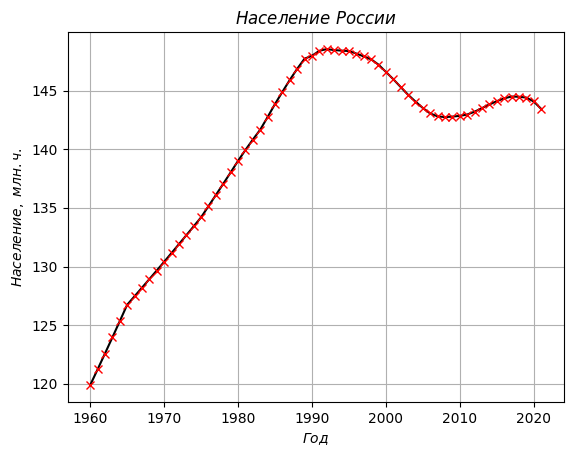

In [2]:
def load(filename="dataset.csv"):
    data = None
    with open(filename) as f:
        lines = f.readlines()
        data = np.empty([2, len(lines)], dtype=np.float64)        
        for i, line in enumerate(lines):
            tokens = line.split(",")

            year = int(tokens[-2])
            numb = int(tokens[-1])

            data[0][i] = year
            data[1][i] = numb
    return data

data = load()
plt.plot(data[0], data[1]*1e-6, "kx-", mec="r")
plt.grid()
plt.title("$Население~ России$")
plt.xlabel("$Год$")
plt.ylabel("$Население,~ млн. ч.$")

In [3]:
def test_interpolation(interpolator, applier, title):
    X = np.array([1, 4, 6, 9])
    Y = np.array([0, 2, -1, 4])

    I = interpolator(X, Y)

    X1 = np.linspace(X[0], X[-1], 1000)
    Y1 = np.array([applier(I, x) for x in X1])

    plt.plot(X, Y, "ro", label="Точки")
    plt.plot(X1, Y1, "k--", label="Интерполяция", zorder=0)
    plt.title(f"$Проверка ~интерполяции:$\n${title}$")
    plt.grid()
    plt.legend()
    plt.show()

## 1. Полиномиальная интерполяция по Ньютону

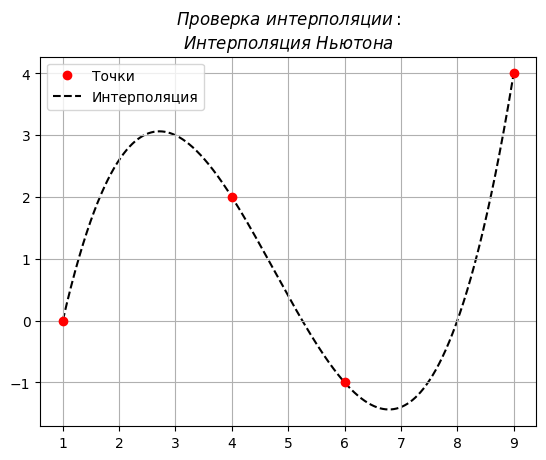

In [4]:
# Рассчет разделенных разностей за O(NlogN)
def divdiff(X, Y):
    N = len(X)

    cached = ([[0]* (N - i) for i in range(N)])

    for i in range(len(cached[0])):
        cached[0][i] = Y[i]

    for i in range(1, len(cached)):
        for j in range(len(cached[i])):
            cached[i][j] = (cached[i - 1][j + 1] - cached[i - 1][j]) / (X[j + i] - X[j])

    return np.array([line[0] for line in cached])

def newton(X, Y):
    return divdiff(X, Y), X

def apply_newton(N, x):
    D, X0 = N
    s = 0

    for i in range(len(X0)):
        m = D[i]
        for j in range(i):
             m *= x - X0[j]
        s += m

    return s

test_interpolation(newton, apply_newton, "Интерполяция~Ньютона")

Text(0.5, 1.0, 'Интерполяция Ньютона при большом числе точек')

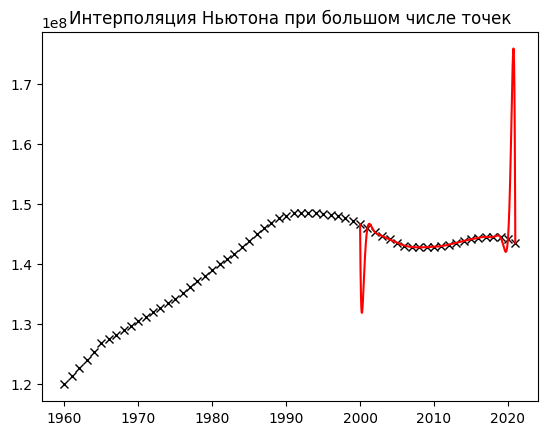

In [5]:
bound = 40
N = newton(data[0][bound:], data[1][bound:])

newX = np.linspace(data[0][bound], data[0][-1], 1000)
newY = [apply_newton(N, x) for x in newX]

plt.plot(newX, newY, "r-")
plt.plot(*data, "kx", mec="k", zorder=0)
plt.title("Интерполяция Ньютона при большом числе точек")

Как мы видим, при большом числе точек у интерполяции Ньютона возникает проблема: При $N$ точках мы получаем полином степени $N$, и при $N >> 1$ появляются значительные граничные эффекты. Поэтому мы "разредим" точки, а так же будем экстраполировать по данным, начиная с 2000 года.

In [6]:
def sparse_data(X, Y, band, npoints=None):
    new_X = []
    new_Y = []
    for x, y in zip(X, Y):
        if x < band[0]: continue
        if x > band[1]: break

        new_X.append(x)
        new_Y.append(y)

    if npoints is None:
        return np.array(new_X), np.array(new_Y)

    step = len(new_X) // (npoints - 1)

    new_X2 = [new_X[i] for i in range(0, len(new_X), step)]
    new_Y2 = [new_Y[i] for i in range(0, len(new_X), step)]

    return np.array(new_X2), np.array(new_Y2)

In [7]:
FUTURE = 10
def extrapolate(interpolator, applier, title, npoints=None):
    sparse_X, sparse_Y = sparse_data(*data, (2000, data[0][-1]), npoints)

    I = interpolator(sparse_X, sparse_Y)

    X = np.linspace(sparse_X[0], sparse_X[-1] + FUTURE, 1000)
    Y = np.array([applier(I, x) for x in X])

    plt.plot(data[0], data[1]*1e-6, "kx", zorder=0, label="$Данные ~переписи~ населения$")
    plt.plot(X, Y*1e-6, "r-", label="$Экстраполяция$")
    plt.xlim((1991, 2030))
    plt.ylim((135, 155))
    plt.grid()
    plt.tight_layout()
    plt.title(f"$Экстраполяция ~населения~ России$\n${title}$")
    plt.xlabel("$Год$")
    plt.ylabel("$Население, млн.ч.$")
    plt.legend()
    plt.show()

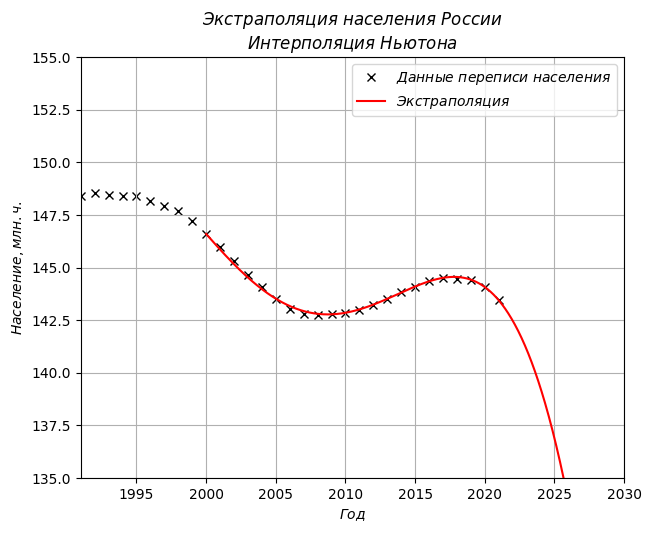

In [8]:
extrapolate(newton, apply_newton, "Интерполяция~ Ньютона", 5)

## 2. Сплайн-интерполяция

Строим кубический сплайн с граничным условием

$S''(a) = S''(b) = 0$

В процессе возникает необходимость решения системы с трехдиагональной матрицей. Ее мы тоже решать методом правой прогонки. 

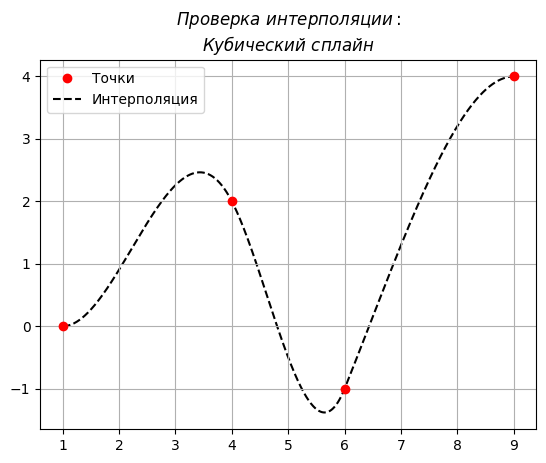

In [9]:
# Решение системы с трехдиагональной матрицей
# A - нижняя диагональ [2, N]
# B - главная диагональ [1, N]
# C - верхняя диагональ [1, N-1]
# F - правая часть
def solve_tridiag(A, B, C, F):
    X = np.empty_like(B)

    C, B = B, C
    C = -C
    F = -F

    alpha = np.empty_like(A)
    alpha[0] = B[0]/C[0]

    for i in range(1, len(alpha)):
        alpha[i] = B[i] / (C[i] - A[i]*alpha[i-1])

    beta = np.empty_like(C)
    beta[0] = F[0]/C[0]

    for i in range(1, len(beta)):
        beta[i] = (F[i] + A[i-1] * beta[i - 1]) / (C[i] - A[i-1]*alpha[i - 1])

    X[-1] = beta[-1]

    for i in reversed(range(len(X)-1)):
        X[i] = alpha[i] * X[i + 1] + beta[i]

    return X


def spline(X, Y):
    tau = X[1:] - X[:-1] # [x_1 - x_0, ..., x_n - x_{n-1}]
    
    dF = Y[1:] - Y[:-1]  # [f_1 - f_0, ..., f_n - f_{n-1}]

    F = dF[1:]/tau[1:] - dF[:-1]/tau[:-1] # [(f_2 - f_1) / tau_1 - (f_1 - f_0) / tau_0, ...]

    B = tau[1:-1] / 6
    C = (tau[:-1] + tau[1:]) / 3

    A = np.zeros([len(F), len(F)])

    for i in range(len(F) - 1):
        A[i][i+1] = B[i]
        A[i+1][i] = B[i]

    for i in range(len(F)):
        A[i][i] = C[i]

    M = np.zeros([len(F) + 2])

    M[1:-1] = solve_tridiag(B, C, B, F)
    
    return X, Y, M, tau

def apply_spline(S, x):
    X, Y, M, tau = S

    i = 0

    if (x <= X[0]): pass
    elif (x >= X[-1]): i = len(M) - 2
    else:
        while i < (len(M) - 1):
            if (x <= X[i]): break
            i+=1
        i-=1

    fn, fn1 = Y[i], Y[i+1]
    mn, mn1 = M[i], M[i+1]
    tn = X[i+1] - X[i]

    z = (x - X[i]) / tn

    s =  fn * (1 - z)**2 * (1 + 2*z)
    s += fn1* z**2 * (3 - 2*z)
    s += mn*tn*z*(1 - z)**2
    s -= mn1 * tn * z**2 * (1 - z)

    return s

test_interpolation(spline, apply_spline, "Кубический~сплайн")

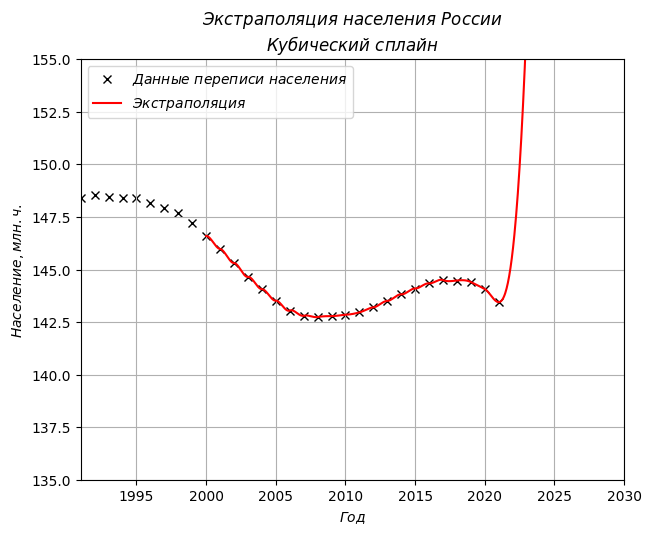

In [10]:
extrapolate(spline, apply_spline, "Кубический~ сплайн")

# 3. Метод Наименьших Квадратов

При помощи МНК будем экстраполировать данные полиномом степени $N$:

$P_N(x) = c_0 + c_1 x^2 + ... + c_N x^N$

Имеем линейную комбинацию степенных функций, МНК сводится к решению СЛАУ относительно $C$

$\Phi C = F$, где

$\Phi_{ij} = \Sigma_k x_k^i x_k^j$

$F_i = \Sigma_k x_k^i y_k$

$x_k, y_k$ - интерполируемые точки

> Комментарий: В процессе метода возникали системы, матрицы которых имели большой разброс значений ~20 порядков, даже после нормировок. Также и определители матриц были очень близки к нулю. Как бы я ни старался, функции из второй лабы не вывозили подобные расчеты (ошибки на порядок отоносительно ```np.linalg.solve```). Поэтому пришлось оставить библиотечную функцию.

> Говоря умными словами, возникали плохо обусловленные системы. В процессе посчитаем число обусловленности $\mu$

mu = 5205137.80111259


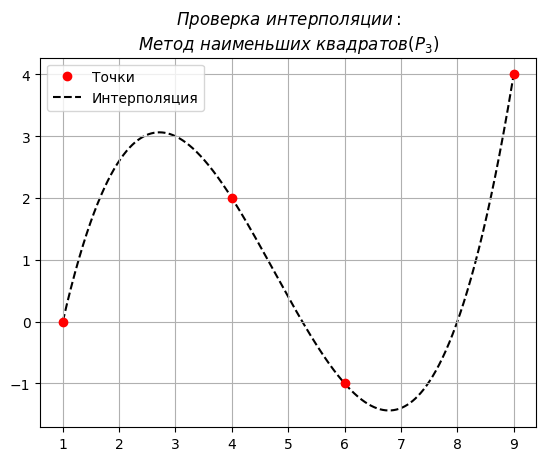

In [11]:
def polyconv(i, j, X):
    return np.sum(X**i * X**j)

def polymat(X, N):
    A = np.empty([N, N])

    for i in range(N):
        A[i][i] = polyconv(i, i, X)
        for j in range(i):
            A[i][j] = polyconv(i, j, X)
            A[j][i] = A[i][j]
    return A

def polyvec(X, Y, N):
    F = np.empty(N)

    for i in range(N):
        F[i] = np.sum(X**i * Y)

    return F

def print_mu(A):
    norm1 = np.max(np.abs(A))
    norm2 = np.max(np.abs(np.linalg.inv(A)))
    print(f"mu = {norm1 * norm2}")

def LSM(X, Y, N):
    A = polymat(X, N)
    F = polyvec(X, Y, N)

    print_mu(A)

    return np.linalg.solve(A, F)

def apply_LSM(P, x):
    s = 0
    for i, c in enumerate(P):
        s += c * x**i
    return s

test_interpolation(lambda X, Y: LSM(X, Y, 4), apply_LSM, "Метод ~наименьших~ квадратов (P_3)")

mu = 6.995986739668252e+72


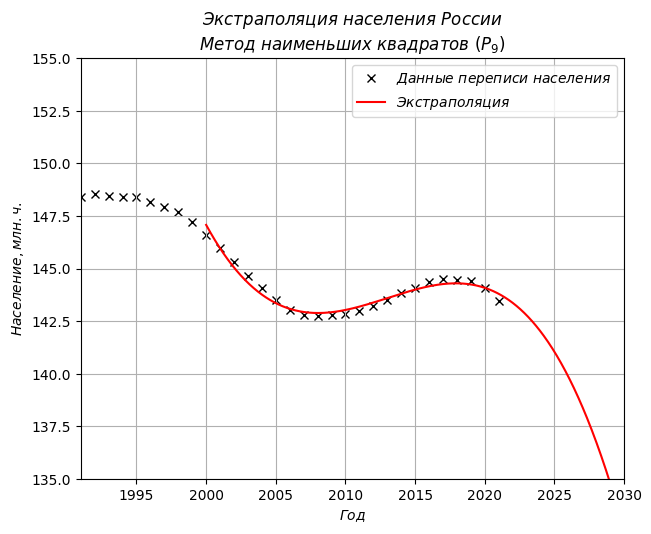

In [12]:
extrapolate(lambda X, Y: LSM(X, Y, 10), apply_LSM, "Метод ~наименьших ~квадратов~ (P_9)")

> В целом выглядит красиво, но $\mu \approx 10^{72}$ очень пугает